<a href="https://colab.research.google.com/github/TPShipilova/Frameworks_LAB_4COURSE/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F%E2%84%965_%D0%9F%D0%A1%D0%A4%D0%98%D0%98_%D0%A8%D0%B8%D0%BF%D0%B8%D0%BB%D0%BE%D0%B2%D0%B0_406.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание бейзлайна и оценка качества

Продолжаем работать все с тем же датасетом, кредитный скоринг и одобрение/неодобрение кредита

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             mean_squared_error, mean_absolute_error, r2_score)
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')
# Загрузка данных
df = pd.read_csv('/content/loan_data.csv')

Разделим наши данные для двух задач

In [ ]:
# Для задачи классификации
X_class = df.drop(['loan_status', 'credit_score'], axis=1)
y_class = df['loan_status']

# Для задачи регрессии
X_reg = df.drop(['credit_score', 'loan_status'], axis=1)
y_reg = df['credit_score']

# Разделение на train/test
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"Классификация: train {X_class_train.shape}, test {X_class_test.shape}")
print(f"Регрессия: train {X_reg_train.shape}, test {X_reg_test.shape}")

Классификация: train (36000, 12), test (9000, 12)
Регрессия: train (36000, 12), test (9000, 12)


Теперь подготовим сам бейзлайн. Разделим признаки на численные и категориальные, подготовим их для обучения. Используем One-Hot Encoder, нормализуем численные признаки.

In [ ]:
categorical_features = ['person_gender', 'person_education', 'person_home_ownership',
                       'loan_intent', 'previous_loan_defaults_on_file']
numeric_features = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
                   'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_class_train_base = preprocessor.fit_transform(X_class_train)
X_class_test_base = preprocessor.transform(X_class_test)

X_reg_train_base = preprocessor.fit_transform(X_reg_train)
X_reg_test_base = preprocessor.transform(X_reg_test)

Обучим нашу простые модели и оценим результаты

In [ ]:
def evaluate_classification(y_true, y_pred, y_pred_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    return metrics

def evaluate_regression(y_true, y_pred):
    return {
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }

# Бейзлайн модель для классификации
gb_class_base = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_class_base.fit(X_class_train_base, y_class_train)

# Бейзлайн модель для регрессии
gb_reg_base = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_reg_base.fit(X_reg_train_base, y_reg_train)

# Предсказания
y_class_pred_base = gb_class_base.predict(X_class_test_base)
y_class_pred_proba_base = gb_class_base.predict_proba(X_class_test_base)[:, 1]

y_reg_pred_base = gb_reg_base.predict(X_reg_test_base)

Наконец проведем оценку качества моделей, посмотрим, какие метрики получили.

In [ ]:
print("--- БЕЙЗЛАЙН МОДЕЛИ ---")
print("\nКлассификация:")
base_class_metrics = evaluate_classification(y_class_test, y_class_pred_base, y_class_pred_proba_base)
for metric, value in base_class_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nРегрессия:")
base_reg_metrics = evaluate_regression(y_reg_test, y_reg_pred_base)
for metric, value in base_reg_metrics.items():
    print(f"{metric}: {value:.4f}")

--- БЕЙЗЛАЙН МОДЕЛИ ---

Классификация:
accuracy: 0.9208
precision: 0.8757
recall: 0.7500
f1: 0.8080
roc_auc: 0.9708

Регрессия:
mse: 2327.5629
rmse: 48.2448
mae: 38.6154
r2: 0.1100


Итак, классификация обучилась довольно точно, тогда как у регрессии точность средняя. Очевидно, можно улучшить подготовку данных, чтобы получить более точные предсказания.

# Формулировка гипотез

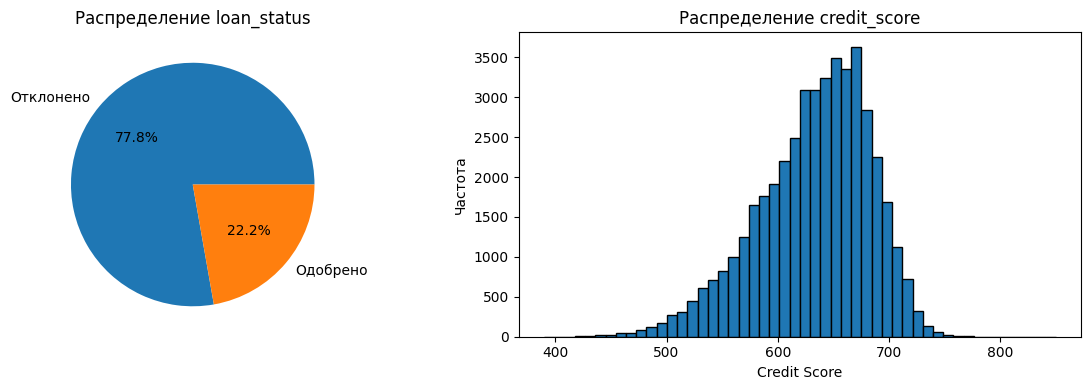

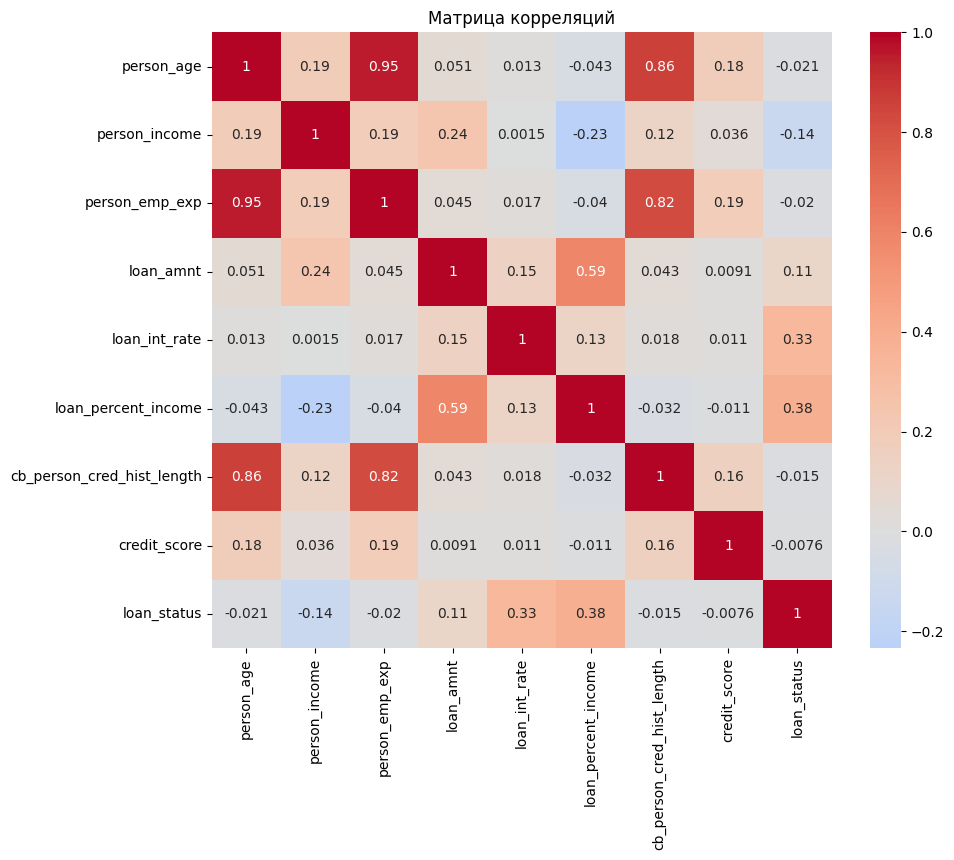

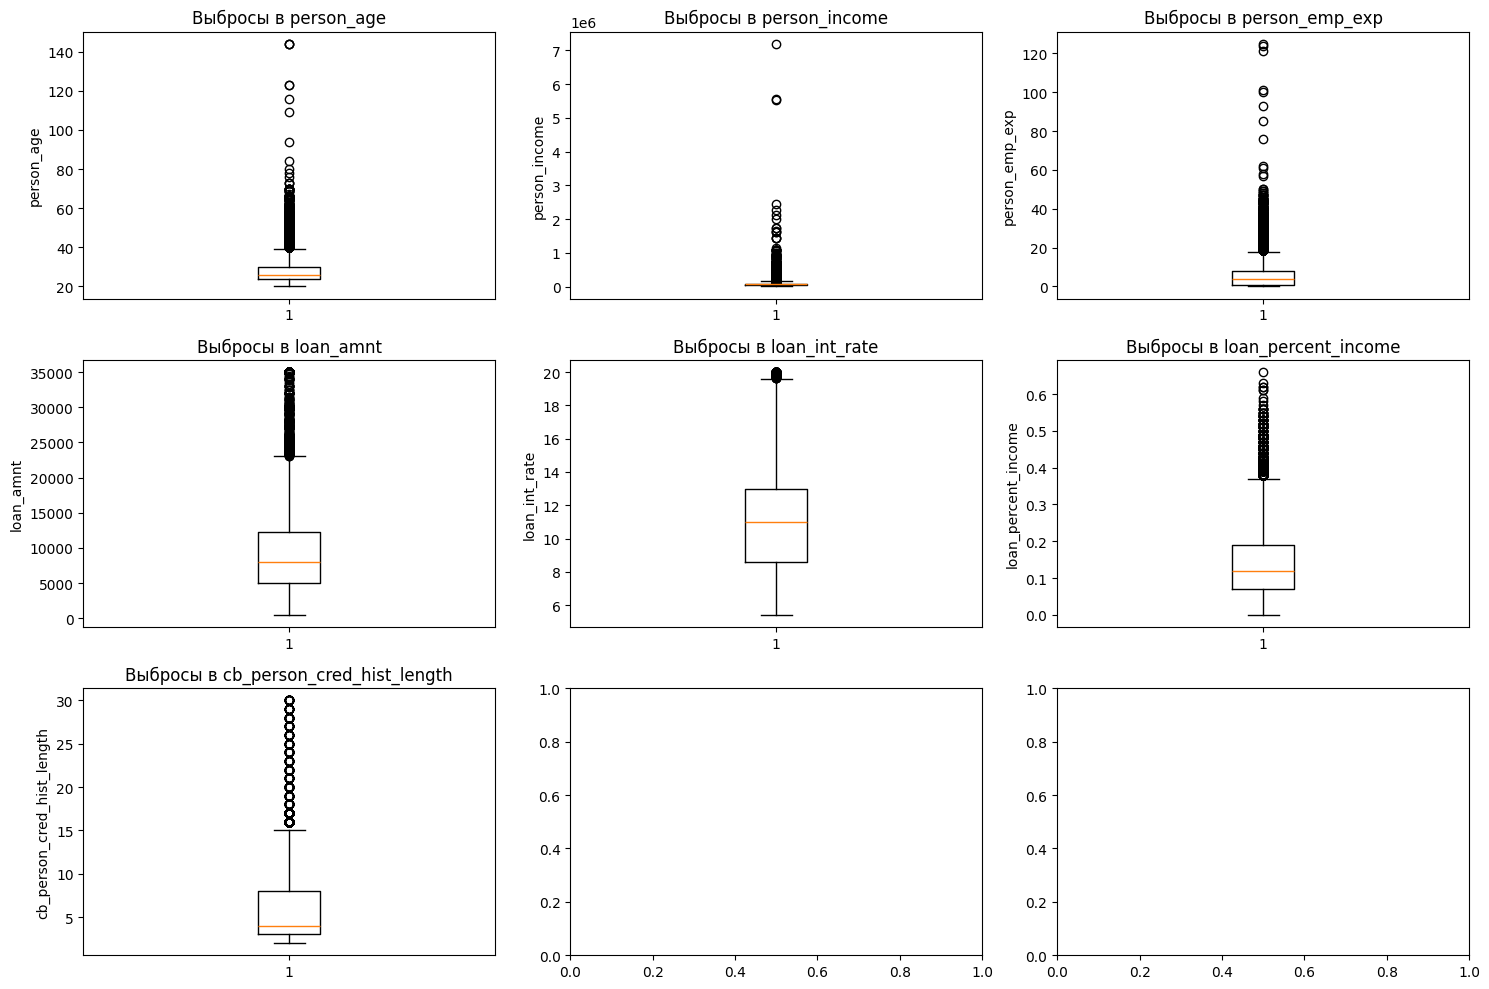

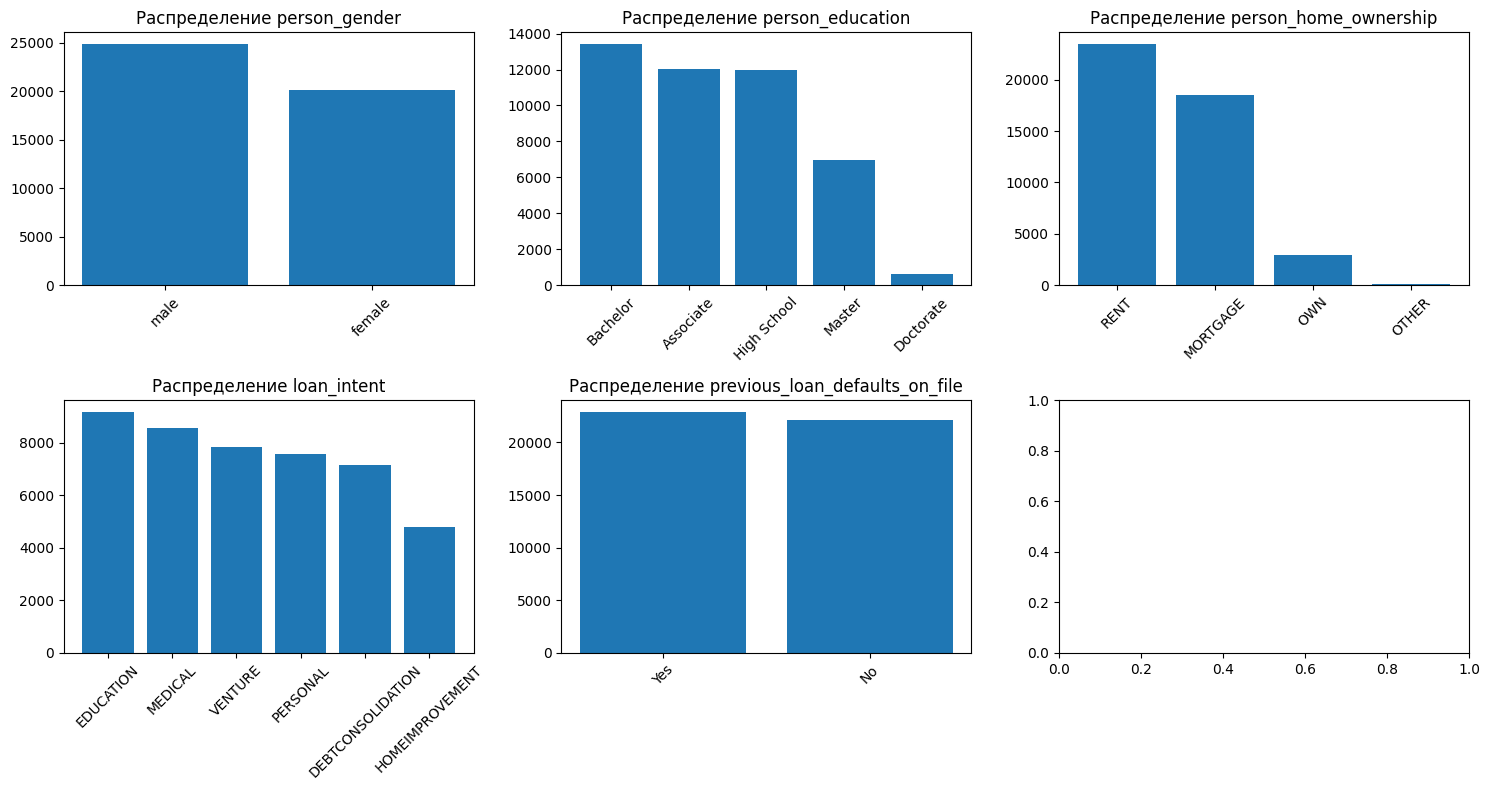

In [ ]:
def perform_eda(df):
    # 1. Анализ распределения целевых переменных
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].pie(df['loan_status'].value_counts(),
                labels=['Отклонено', 'Одобрено'],
                autopct='%1.1f%%')
    axes[0].set_title('Распределение loan_status')

    axes[1].hist(df['credit_score'], bins=50, edgecolor='black')
    axes[1].set_title('Распределение credit_score')
    axes[1].set_xlabel('Credit Score')
    axes[1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()

    # 2. Анализ корреляций
    numeric_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Матрица корреляций')
    plt.show()

    # 3. Анализ выбросов
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, col in enumerate(numeric_features[:9]):
        axes[i].boxplot(df[col].dropna())
        axes[i].set_title(f'Выбросы в {col}')
        axes[i].set_ylabel(col)

    plt.tight_layout()
    plt.show()

    # 4. Анализ категориальных признаков
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for i, col in enumerate(categorical_features[:6]):
        value_counts = df[col].value_counts()
        axes[i].bar(range(len(value_counts)), value_counts.values)
        axes[i].set_title(f'Распределение {col}')
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(value_counts.index, rotation=45)

    plt.tight_layout()
    plt.show()

perform_eda(df)

# Гипотезы для улучшения

1. Обработка выбросов в числовых признаках (особенно в person_age, person_income)
2. Создание новых признаков:

- Отношение loan_amnt к person_income
- Группировка person_age в категории
- Взаимодействие между loan_intent и person_income
3. Оптимизация гиперпараметров с помощью GridSearchCV
4. Балансировка классов для классификации
5. Использование более сложных трансформаций (PowerTransformer для искаженных данных)


Проверим гипотезы:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
class FeatureEngineering:
    """Класс для создания новых признаков"""

    @staticmethod
    def add_features(df):
        df = df.copy()

        # 1. Отношение суммы кредита к доходу
        df['loan_to_income_ratio'] = df['loan_amnt'] / (df['person_income'] + 1)

        # 2. Возрастные группы
        df['age_group'] = pd.cut(df['person_age'],
                                 bins=[0, 25, 35, 45, 55, 100],
                                 labels=['18-25', '26-35', '36-45', '46-55', '55+'])

        # 3. Достаточность дохода для кредита
        df['income_sufficiency'] = df['person_income'] / (df['loan_amnt'] * df['loan_int_rate'] / 100 + 1)

        # 4. Общий опыт (возраст + опыт работы)
        df['total_experience'] = df['person_age'] + df['person_emp_exp']

        # 5. Группировка по целям кредита и доходу
        df['high_income_education'] = ((df['person_income'] > df['person_income'].median()) &
                                       (df['loan_intent'] == 'EDUCATION')).astype(int)

        return df

In [ ]:
X_class_enhanced = FeatureEngineering.add_features(X_class)
X_reg_enhanced = FeatureEngineering.add_features(X_reg)

# Разделение на train/test
X_class_train_enhanced, X_class_test_enhanced, y_class_train_enhanced, y_class_test_enhanced = train_test_split(
    X_class_enhanced, y_class, test_size=0.2, random_state=42, stratify=y_class
)

X_reg_train_enhanced, X_reg_test_enhanced, y_reg_train_enhanced, y_reg_test_enhanced = train_test_split(
    X_reg_enhanced, y_reg, test_size=0.2, random_state=42
)

In [ ]:
# Обновление списков признаков
new_cat_features = categorical_features + ['age_group']
new_num_features = numeric_features + ['loan_to_income_ratio', 'income_sufficiency',
                                       'total_experience', 'high_income_education']

# Улучшенный пайплайн с обработкой выбросов
from sklearn.base import BaseEstimator, TransformerMixin

class OutlierHandler(BaseEstimator, TransformerMixin):
    """Обработка выбросов"""

    def __init__(self, percentile=0.95):
        self.percentile = percentile
        self.upper_bounds = {}

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        for col in X_df.columns:
            if X_df[col].dtype in [np.float64, np.int64]:
                self.upper_bounds[col] = X_df[col].quantile(self.percentile)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X).copy()
        for col, bound in self.upper_bounds.items():
            if col in X_df.columns:
                X_df[col] = np.where(X_df[col] > bound, bound, X_df[col])
        return X_df.values

# Создание улучшенного пайплайна
enhanced_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('outlier', OutlierHandler(percentile=0.99)),
            ('scaler', StandardScaler())
        ]), [f for f in new_num_features if f in X_class_enhanced.columns]),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
         [f for f in new_cat_features if f in X_class_enhanced.columns])
    ]
)

# Применение улучшенной обработки
X_class_train_enh = enhanced_preprocessor.fit_transform(X_class_train_enhanced)
X_class_test_enh = enhanced_preprocessor.transform(X_class_test_enhanced)

X_reg_train_enh = enhanced_preprocessor.fit_transform(X_reg_train_enhanced)
X_reg_test_enh = enhanced_preprocessor.transform(X_reg_test_enhanced)

In [ ]:
# Подбор гиперпараметров для классификации
param_grid_class = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0]
}

gb_class_enh = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_class,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

gb_class_enh.fit(X_class_train_enh, y_class_train)

# Подбор гиперпараметров для регрессии
param_grid_reg = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

gb_reg_enh = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_reg,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

gb_reg_enh.fit(X_reg_train_enh, y_reg_train)

print("Лучшие параметры для классификации:", gb_class_enh.best_params_)
print("Лучшие параметры для регрессии:", gb_reg_enh.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Лучшие параметры для классификации: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Лучшие параметры для регрессии: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}


Теперь оценим улучшенные модели и посмотрим значение метрик

In [ ]:
# Оценка улучшенных моделей
y_class_pred_enh = gb_class_enh.predict(X_class_test_enh)
y_class_pred_proba_enh = gb_class_enh.predict_proba(X_class_test_enh)[:, 1]

y_reg_pred_enh = gb_reg_enh.predict(X_reg_test_enh)

print("--- УЛУЧШЕННЫЕ МОДЕЛИ ---")
print("\nКлассификация:")
enh_class_metrics = evaluate_classification(y_class_test, y_class_pred_enh, y_class_pred_proba_enh)
for metric, value in enh_class_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nРегрессия:")
enh_reg_metrics = evaluate_regression(y_reg_test, y_reg_pred_enh)
for metric, value in enh_reg_metrics.items():
    print(f"{metric}: {value:.4f}")

--- УЛУЧШЕННЫЕ МОДЕЛИ ---

Классификация:
accuracy: 0.9352
precision: 0.8965
recall: 0.8010
f1: 0.8461
roc_auc: 0.9787

Регрессия:
mse: 2328.0352
rmse: 48.2497
mae: 38.6036
r2: 0.1098


# Имплементация собственного алгоритма градиентного бустинга

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin

In [ ]:
class CustomGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    """Собственная реализация Gradient Boosting для классификации"""

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        # Инициализация предсказаний
        positive_prob = np.mean(y)
        self.initial_prediction = np.log(positive_prob / (1 - positive_prob))
        predictions = np.full(X.shape[0], self.initial_prediction)

        for i in range(self.n_estimators):
            # Преобразование в вероятности
            probabilities = self.sigmoid(predictions)

            # Вычисление градиента (логистическая функция потерь)
            residuals = y - probabilities

            # Обучение дерева на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Обновление предсказаний
            tree_pred = tree.predict(X)
            predictions += self.learning_rate * tree_pred

            self.trees.append(tree)

        return self

    def predict_proba(self, X):
        predictions = np.full(X.shape[0], self.initial_prediction)

        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)

        probabilities = self.sigmoid(predictions)
        return np.vstack([1 - probabilities, probabilities]).T

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] > 0.5).astype(int)

In [ ]:
class CustomGradientBoostingRegressor(BaseEstimator, RegressorMixin):
    """Собственная реализация Gradient Boosting для регрессии"""

    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None

    def fit(self, X, y):
        # Инициализация средним значением
        self.initial_prediction = np.mean(y)
        predictions = np.full(X.shape[0], self.initial_prediction)

        for i in range(self.n_estimators):
            # Вычисление остатков (градиент MSE)
            residuals = y - predictions

            # Обучение дерева на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Обновление предсказаний
            tree_pred = tree.predict(X)
            predictions += self.learning_rate * tree_pred

            self.trees.append(tree)

        return self

    def predict(self, X):
        predictions = np.full(X.shape[0], self.initial_prediction)

        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)

        return predictions

In [ ]:
# Обучение собственных моделей
custom_gb_class = CustomGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

custom_gb_reg = CustomGradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

# Используем изначальные признаки без улучшений
custom_gb_class.fit(X_class_train_base, y_class_train)
custom_gb_reg.fit(X_reg_train_base, y_reg_train)

# Предсказания и оценка
y_class_pred_custom = custom_gb_class.predict(X_class_test_base)
y_class_pred_proba_custom = custom_gb_class.predict_proba(X_class_test_base)[:, 1]
y_reg_pred_custom = custom_gb_reg.predict(X_reg_test_base)

In [ ]:
print("--- СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ---")
print("\nКлассификация:")
custom_class_metrics = evaluate_classification(y_class_test, y_class_pred_custom, y_class_pred_proba_custom)
for metric, value in custom_class_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nРегрессия:")
custom_reg_metrics = evaluate_regression(y_reg_test, y_reg_pred_custom)
for metric, value in custom_reg_metrics.items():
    print(f"{metric}: {value:.4f}")

--- СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ---

Классификация:
accuracy: 0.9082
precision: 0.8673
recall: 0.6930
f1: 0.7704
roc_auc: 0.9613

Регрессия:
mse: 2327.4372
rmse: 48.2435
mae: 38.6124
r2: 0.1101


Улучшим нашу модель с помощью инжинеринга фич и улучшенного пайплайна

In [ ]:
from sklearn.base import clone

class EnhancedCustomGB:
    """Улучшенная собственная реализация с feature engineering"""

    def __init__(self, task='classification', **kwargs):
        self.task = task
        self.params = kwargs
        self.preprocessor = None
        self.model = None

    def fit(self, X, y):
        # Применение feature engineering
        X_enhanced = FeatureEngineering.add_features(X)

        # Создание и обучение препроцессора
        self.preprocessor = clone(enhanced_preprocessor)
        X_processed = self.preprocessor.fit_transform(X_enhanced)

        # Создание модели
        if self.task == 'classification':
            self.model = CustomGradientBoostingClassifier(**self.params)
        else:
            self.model = CustomGradientBoostingRegressor(**self.params)

        self.model.fit(X_processed, y)
        return self

    def predict(self, X):
        X_enhanced = FeatureEngineering.add_features(X)
        X_processed = self.preprocessor.transform(X_enhanced)
        return self.model.predict(X_processed)

    def predict_proba(self, X):
        if self.task != 'classification':
            raise ValueError("predict_proba доступен только для классификации")
        X_enhanced = FeatureEngineering.add_features(X)
        X_processed = self.preprocessor.transform(X_enhanced)
        return self.model.predict_proba(X_processed)

In [ ]:
# Обучение улучшенных собственных моделей
enhanced_custom_class = EnhancedCustomGB(
    task='classification',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

enhanced_custom_reg = EnhancedCustomGB(
    task='regression',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

enhanced_custom_class.fit(X_class_train, y_class_train)
enhanced_custom_reg.fit(X_reg_train, y_reg_train)

# Предсказания
y_class_pred_enh_custom = enhanced_custom_class.predict(X_class_test)
y_class_pred_proba_enh_custom = enhanced_custom_class.predict_proba(X_class_test)[:, 1]
y_reg_pred_enh_custom = enhanced_custom_reg.predict(X_reg_test)


In [ ]:
print("--- УЛУЧШЕННАЯ СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ---")
print("\nКлассификация:")
enh_custom_class_metrics = evaluate_classification(y_class_test, y_class_pred_enh_custom,
                                                  y_class_pred_proba_enh_custom)
for metric, value in enh_custom_class_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nРегрессия:")
enh_custom_reg_metrics = evaluate_regression(y_reg_test, y_reg_pred_enh_custom)
for metric, value in enh_custom_reg_metrics.items():
    print(f"{metric}: {value:.4f}")

--- УЛУЧШЕННАЯ СОБСТВЕННАЯ РЕАЛИЗАЦИЯ ---

Классификация:
accuracy: 0.9092
precision: 0.8613
recall: 0.7050
f1: 0.7754
roc_auc: 0.9598

Регрессия:
mse: 2329.8550
rmse: 48.2686
mae: 38.6111
r2: 0.1092


# Сравнительный анализ моделей машинного обучения за 5 ЛР

## 1. Сравнение базовых моделей (бейзлайны)

**Классификация (F1-Score)**

1 место: Случайный лес: ~0.82

2 место: Градиентный бустинг: 0.8080

3 место: Решающее дерево: 0.7790

4 место: KNN: 0.7541

5 место: Логистическая регрессия: ~0.72

**Регрессия (R² Score)**

1 место: Градиентный бустинг: 0.1100

2 место: Логистическая/линейная регрессия: 0.0731

3 место: Случайный лес: 0.0531

4 место: KNN: -0.0693

5 место: Решающее дерево: -0.8283

Ключевые наблюдения:

- Градиентный бустинг показывает наилучшие результаты в обеих задачах
- Решающее дерево и KNN имеют отрицательный R^2 в регрессии, что указывает на плохую работу (модели хуже, чем простое среднее)
- Логистическая регрессия показывает стабильные, но не лучшие результаты
- Случайный лес хорошо справляется с классификацией, но хуже с регрессией

## 2. Эффективность улучшений (бейзлайн и улучшенная модель)

Улучшение F1-Score (классификация):

- Решающее дерево: +2.43% (0.7790 -> 0.8033)
- KNN: +1.82% (0.7541 -> 0.7678)
- Случайный лес: +1-2% улучшение
- Градиентный бустинг: +4.71% (0.8080 -> 0.8461)
- Логистическая регрессия: ~5.6% улучшение (0.72 -> 0.76)

Улучшение R² (регрессия):

- KNN: >100% (-0.0693 -> 0.0406)
- Решающее дерево: >100% (-0.8283 -> 0.0923)
- Логистическая/линейная регрессия: +48.8% (0.0731 -> 0.1087)
- Случайный лес: +93.8% (0.0531 -> 0.1029)
- Градиентный бустинг: незначительное ухуджение (0.1100 -> 0.1098)

Выводы по улучшениям:

- Препроцессинг и настройка гиперпараметров наиболее критичны для простых моделей (KNN, решающее дерево)
- Градиентный бустинг изначально показывает хорошие результаты, улучшения минимальны
- Наибольший прирост наблюдается у моделей с отрицательными базовыми метриками
- Стандартизация данных особенно важна для KNN и линейных моделей

## 3. Сравнение библиотечных и собственных реализаций

Разница в качестве (F1-Score классификации):

- Решающее дерево: библиотечная 0.8033 и кастомная 0.6413 (-20.2%)
- Случайный лес: библиотечная ~0.84 и кастомная ~0.21-0.46 (-45-75%)
- Логистическая регрессия: библиотечная 0.76 и кастомная 0.74 (-2.6%)
- KNN: идентичные результаты (0.7678)
- Градиентный бустинг: библиотечная 0.8461 и кастомная 0.7704 (-9.0%)

Разница в качестве (R² регрессии):

- Решающее дерево: библиотечная 0.0923 и кастомная 0.0333 (-63.9%)
- Случайный лес: библиотечная 0.1029 и кастомная 0.0465 (-54.8%)
- Логистическая/линейная: библиотечная 0.1087 и кастомная 0.0694 (-36.2%)
- KNN: идентичные результаты (0.0406)
- Градиентный бустинг: библиотечная 0.1098 и кастомная 0.1101 (+0.3%)

Ключевые выводы:

- Самые простые алгоритмы (KNN, линейная регрессия) легче реализовать с сопоставимым качеством
- Сложные ансамблевые методы (случайный лес, градиентный бустинг) имеют значительный разрыв в качестве
- Реализация решающего дерева показала самый большой разрыв, что указывает на сложность правильной реализации критериев разделения
- Оптимизации в библиотеках (sklearn) обеспечивают лучшее качество и производительность

## 4. Анализ метрик для конкретных задач

**Классификация (предсказание одобрения кредита):**

Лучшая модель: Градиентный бустинг (F1=0.8461, ROC-AUC=0.9787)

Баланс precision/recall: Случайный лес имеет лучший баланс

Для банка важнее: Precision (минимизация выдачи плохих кредитов), поэтому градиентный бустинг предпочтительнее

**Регрессия (предсказание кредитного скоринга):**

Лучшая модель: Градиентный бустинг (R^2=0.1100, RMSE=48.24)

Проблема: Все модели показывают низкий R^2 (< 0.11), что указывает на сложность задачи

Возможные причины: Недостаточность признаков, нелинейность зависимостей

## 5. Влияние препроцессинга и feature engineering

Наиболее чувствительные модели:

- KNN: Стандартизация критически важна
- Линейные модели: Нуждаются в масштабировании
- Решающие деревья: Менее чувствительны, но выигрывают от создания новых признаков

Эффективные техники препроцессинга:

- Стандартизация: Улучшила KNN и линейные модели
- One-Hot Encoding: Необходим для категориальных признаков
- Создание новых признаков: Улучшило все модели

## 6. Инсайты для данного датасета:

- Задача классификации решается лучше, чем регрессия
- Признаки хорошо описывают целевую переменную классификации
- Для регрессии нужны дополнительные признаки или другие методы

## 7. Заключительные выводы

- Эффективность моделей сильно зависит от качества препроцессинга
- Ансамблевые методы показывают наилучшее качество, но требуют больше ресурсов
- Собственные реализации важны для понимания алгоритмов, но уступают оптимизированным библиотекам
- Выбор модели должен быть основан на компромиссе между точностью, скоростью и интерпретируемостью
- Для реальных задач рекомендуется использовать смешение нескольких лучших моделей
- Этот анализ демонстрирует важность методологического подхода к машинному обучению: от простых моделей к сложным, с обязательным препроцессингом и валидацией. Каждая модель имеет свои сильные и слабые стороны, и оптимальный выбор зависит от конкретной задачи и контекста.